<a href="https://colab.research.google.com/github/pedrocz82/Data-Science-learning-projects/blob/main/Imbalanced_data_Fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Credit Card Fraud Detection**

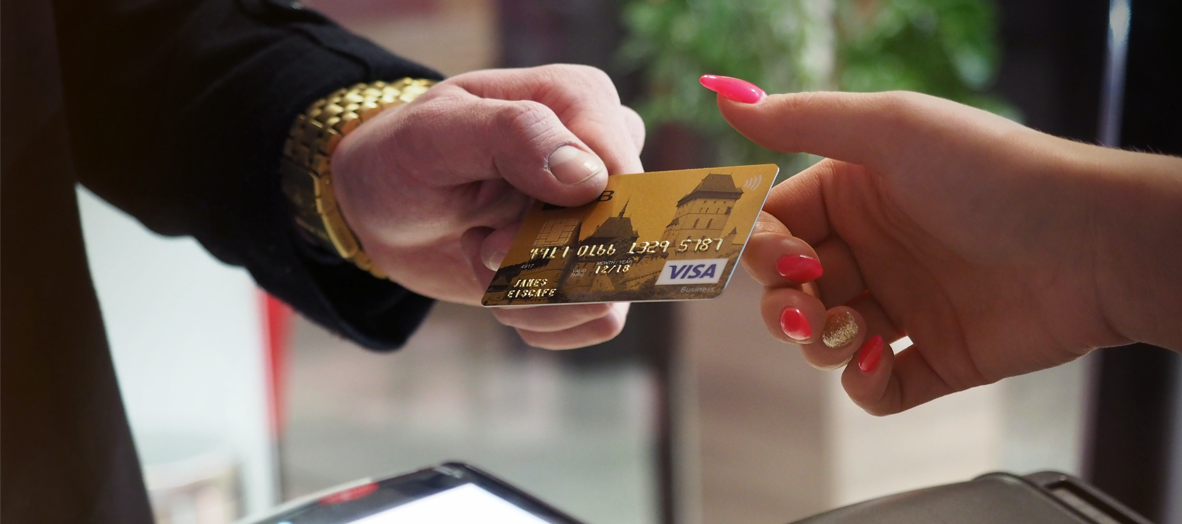

#**1. Introduction**

The Fraud practice is prevalent in human actions along all economic activities, among which is the credit card fraud. The consequences of this action have impact on company´s reputation as well as financial losses [1].<br>Hence, fraud detection and prevention becomes necessary. <br>Machine learning models can be helpful in building models to prevent fraud, finding patterns based on a dataset.<br>In this work, the objective is build a Machine Learning model from a Kaggle dataset [2] to detect Fraud.

**Dataset**

This dataset describes transactions of 2 in two days, containing 492 frauds out of 284,807 transactions. The chalange of this dataset is its highly unbalanced, being the positive class, (frauds) 0.172% of all transactions.

All the variables are numerical, result of a PCA transformation. Due to confidentiality issues, the original features are not provided. V1 up to V28 are the principal components obtained with PCA. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, used for example-dependent cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [1]:
#importing main libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

In [2]:
df = pd.read_csv('/content/sample_data/creditcard.csv')

**Preliminary Dataset informations**

Since the PCA is sensitive to the scale of variables, it is assumed that the original *features* were standardized.

In [3]:
df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
#checking for missing values, missing values/total and type in df dataset
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [6]:
#data distribution
def histogram(dataframe, features, rows, cols):
  fig = plt.figure(figsize=(20,20))
  for i, feature in enumerate(features):
    ax = fig.add_subplot(rows, cols, i+1)
    dataframe[feature].hist(bins=20, ax=ax, facecolor='midnightblue')
    ax.set_title(feature+' Distribution', color='DarkRed')
    ax.set_yscale('log')
  fig.tight_layout()
  plt.show()

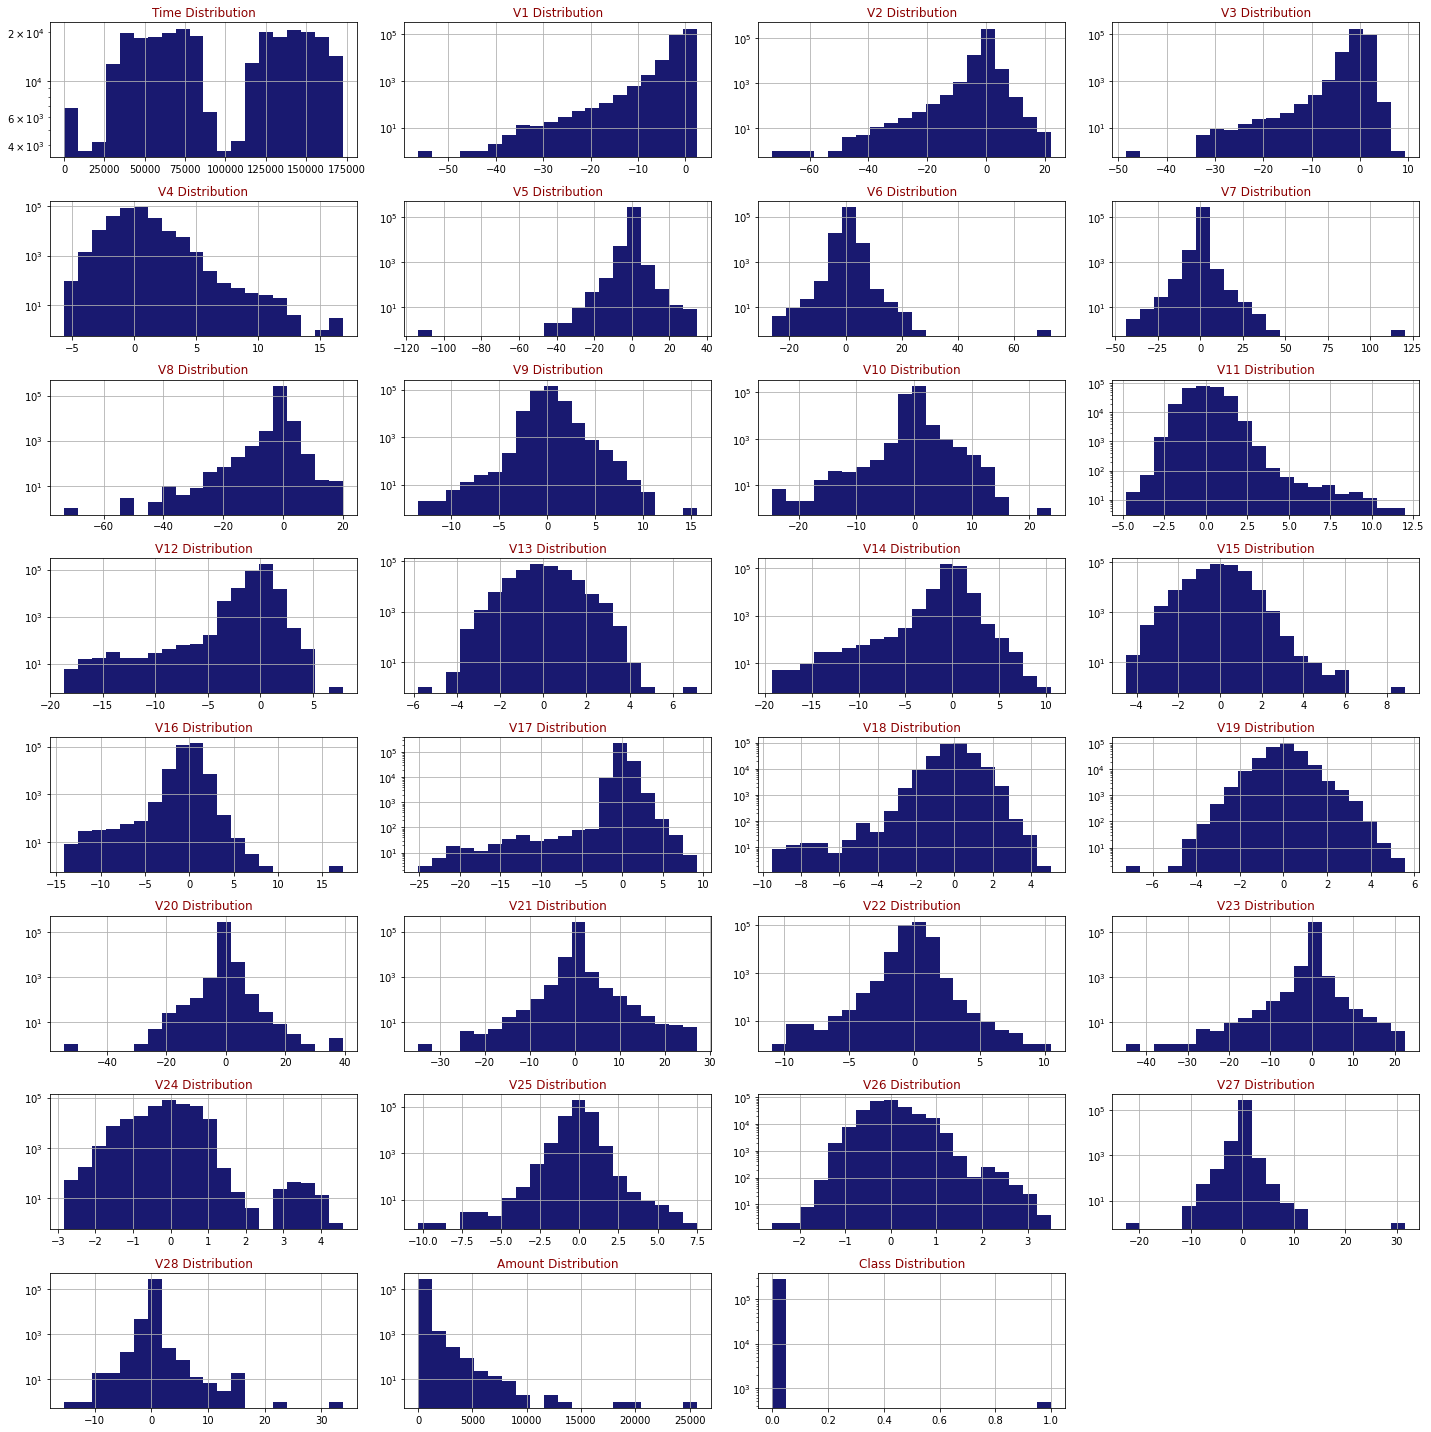

In [7]:
histogram(df, df.columns, 8, 4)

Time and Amount columns are not normalized.

In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
std_scaler = StandardScaler()
df['std_amount'] = std_scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['std_time'] = std_scaler.fit_transform(df['Time'].values.reshape(-1, 1))

df.drop(['Time', 'Amount'], axis=1, inplace=True)

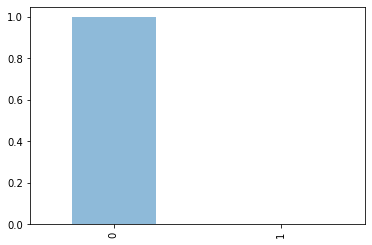

In [10]:
df.Class.value_counts(normalize=True).plot(kind = 'bar', alpha = 0.5)

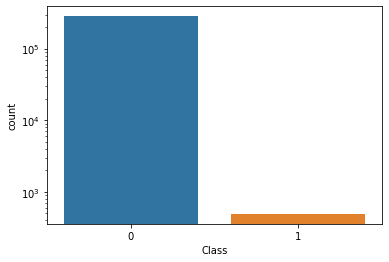

In [11]:
#log transforming
ax=sns.countplot(x='Class', data=df)
ax.set_yscale('log')

In [12]:
df.Class.unique()

array([0, 1])

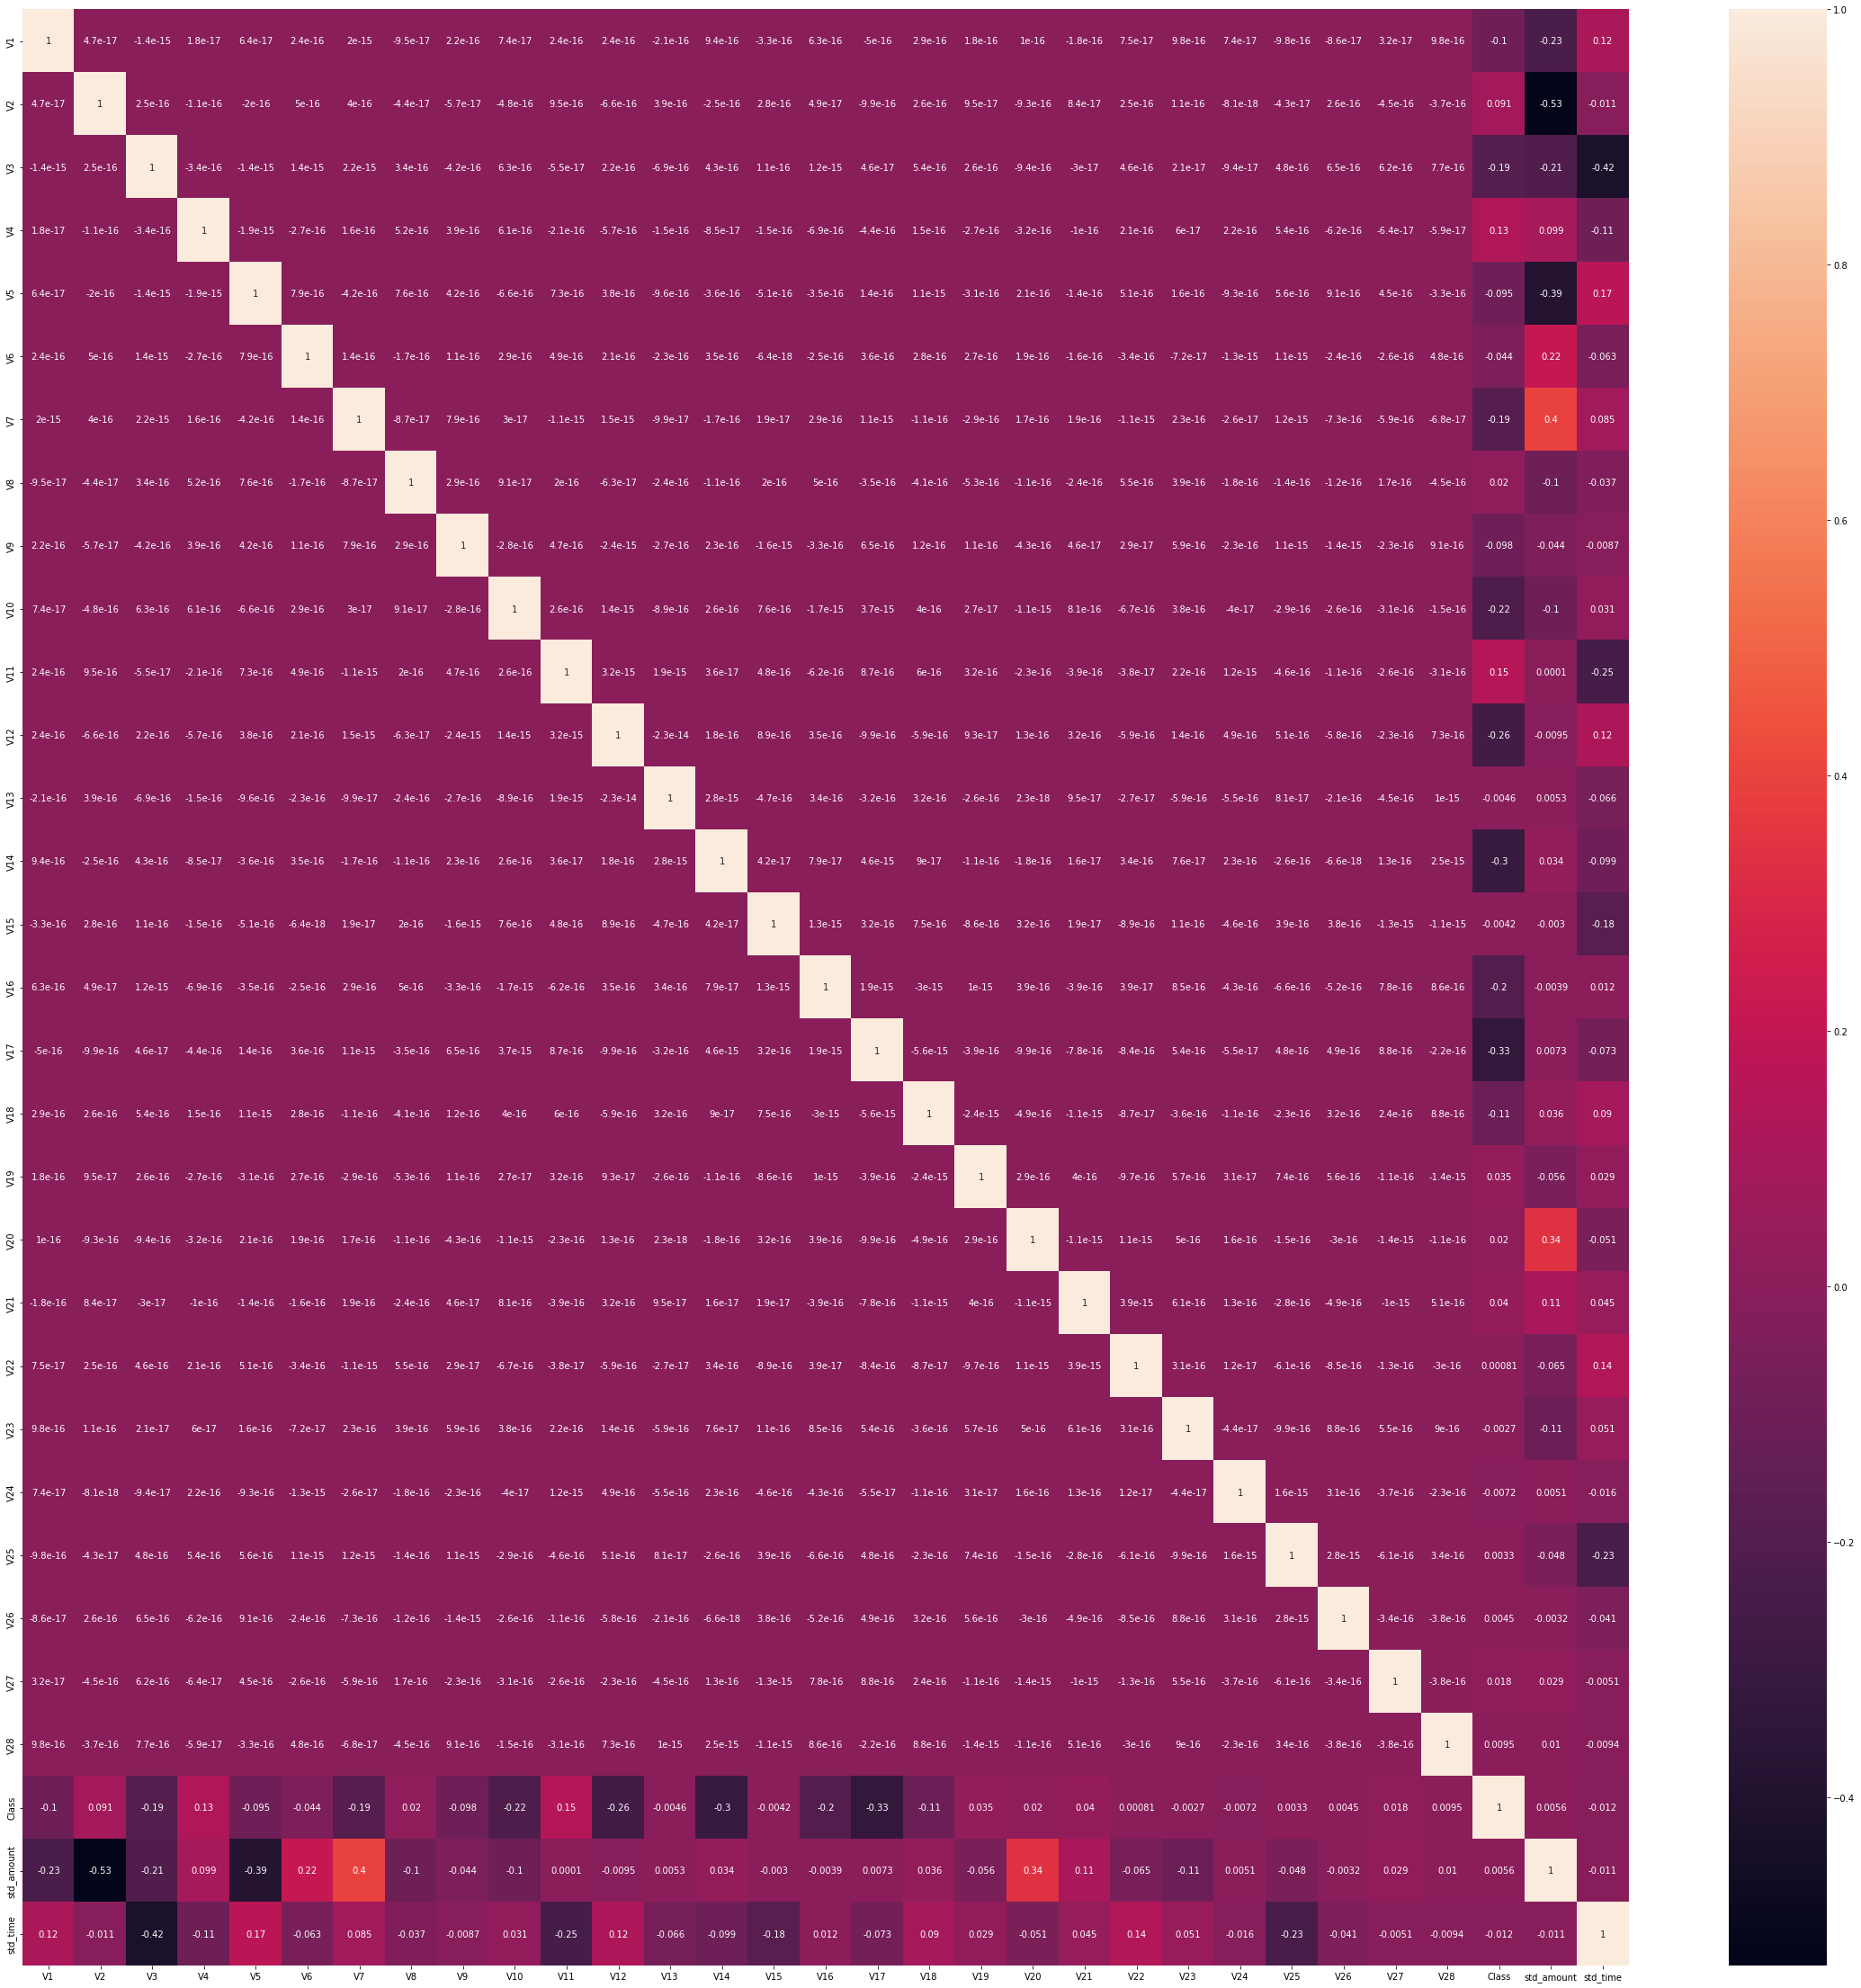

In [13]:
#correlation between variables
correlations = df.corr()
f, ax = plt.subplots(figsize = (40, 40))
sns.heatmap(correlations, annot = True)

**Dealing with imbalanced data [3,4]**

Datasets in which one class has a much more different distribution than the other are often called imbalanced datasets or data sets with imbalanced classes. <br>
There are some techniques applied to deal with imbalanced data. In this work, 3 techniques will be used:
* **Oversampling minority class**: It consists of replicating random data from the minority class. As we are duplicating existing data this method is prone to overfitting.
* **Undersampling minority class**: It consists of randomly reducing the examples of the majority class.
* **SMOTE**: It consists of generating synthetic data (not duplicated) of the minority class from neighbors.

In [14]:
X = df.drop('Class', axis=1)
y = df['Class']

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

**Oversampling minority class**

In [17]:
from sklearn.utils import resample

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_fraud = X[X.Class==0]
fraud = X[X.Class==1]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled.Class.value_counts()

1    199008
0    199008
Name: Class, dtype: int64

In [18]:
# RandomForest with the balanced dataset

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

y_train = upsampled.Class
X_train = upsampled.drop('Class', axis=1)

upsampled = rfc.fit(X_train, y_train)

y_pred = upsampled.predict(X_test)

In [19]:
!pip install scikit-plot

Classification report:
               precision    recall  f1-score   support

           0     0.9997    0.9999    0.9998     85307
           1     0.9565    0.8088    0.8765       136

    accuracy                         0.9996     85443
   macro avg     0.9781    0.9044    0.9382     85443
weighted avg     0.9996    0.9996    0.9996     85443

Accuracy: 0.9996

AUC: 0.9044



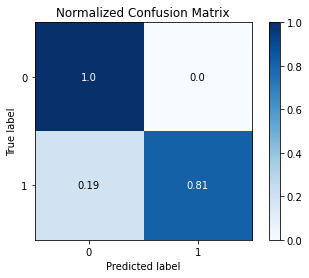

In [20]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

print("Classification report:\n", classification_report(y_test, y_pred, digits=4))


print("Accuracy: {:.4f}\n".format(accuracy_score(y_test, y_pred)))


print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

**Undersampling majority class**

In [21]:
# still using our separated classes fraud and not_fraud from above

# downsample majority
not_fraud_downsampled = resample(not_fraud,
                                replace = False, # sample without replacement
                                n_samples = len(fraud), # match minority n
                                random_state = 27) # reproducible results



# combine minority and downsampled majority
downsampled = pd.concat([not_fraud_downsampled, fraud])

# checking counts
downsampled.Class.value_counts()

1    356
0    356
Name: Class, dtype: int64

In [22]:
y_train = downsampled.Class
X_train = downsampled.drop('Class', axis=1)


undersampled = rfc.fit(X_train, y_train)

y_pred = undersampled.predict(X_test)

Classification report:
               precision    recall  f1-score   support

           0     0.9999    0.9742    0.9869     85307
           1     0.0546    0.9338    0.1032       136

    accuracy                         0.9742     85443
   macro avg     0.5272    0.9540    0.5450     85443
weighted avg     0.9984    0.9742    0.9855     85443

Accuracy: 0.9742

AUC: 0.9540



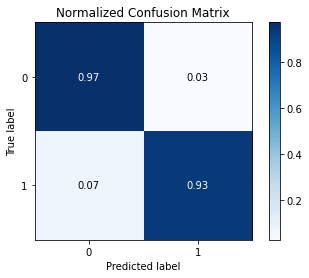

In [23]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

print("Classification report:\n", classification_report(y_test, y_pred, digits=4))


print("Accuracy: {:.4f}\n".format(accuracy_score(y_test, y_pred)))


print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

**Synthetic Samples - SMOTE**

In [24]:
from imblearn.over_sampling import SMOTE


X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

sm = SMOTE(random_state=27, ratio=1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [25]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

smote = RandomForestClassifier()
smote.fit(X_train, y_train)

y_pred = smote.predict(X_test)

Classification report:
               precision    recall  f1-score   support

           0     0.9997    0.9998    0.9997     71070
           1     0.8871    0.8333    0.8594       132

    accuracy                         0.9995     71202
   macro avg     0.9434    0.9166    0.9296     71202
weighted avg     0.9995    0.9995    0.9995     71202

Accuracy: 0.9995

AUC: 0.9166



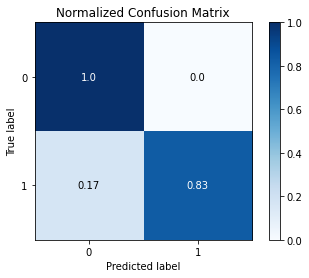

In [26]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

print("Classification report:\n", classification_report(y_test, y_pred, digits=4))


print("Accuracy: {:.4f}\n".format(accuracy_score(y_test, y_pred)))


print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

##**2.Conclusion**

In this work, it was explored 3 methods for dealing with imbalanced dataset:
Oversample minority class, Undersample majority class and SMOTE.

Random forest showed a good model to run with this 3 methods, achieving high metric values. SMOTE and oversampling were the best sampling methods. 

##**3.References**
* [1] Dal Pozzolo, Andrea Adaptive Machine learning for credit card fraud detection ULB MLG PhD thesis (supervised by G. Bontempi)
* [2] https://www.kaggle.com/mlg-ulb/creditcardfraud
* [3] https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18
* [4] Introduction to Machine Learning with Python; Muller, AC, Guido, S.; 2017

I am thankful for RODNAE Productions from Pexel Photo
